In [1]:
pip install pyodbc

Note: you may need to restart the kernel to use updated packages.


✅ Quotations table created.
✅ Inventory table created successfully!
✅ OrderConfirmed column ensured.
✅ Duplicate products removed.
✅ Unique constraint added to ProductName.
🔧 Foreign key constraints temporarily disabled.
🔧 Foreign key constraints re-enabled.
✅ Inventory table reset successfully.
✅ Dummy data inserted successfully!
✅ Suppliers table created successfully!
✅ Sample supplier records inserted successfully (No duplicates added)!
✅ Orders table created successfully!


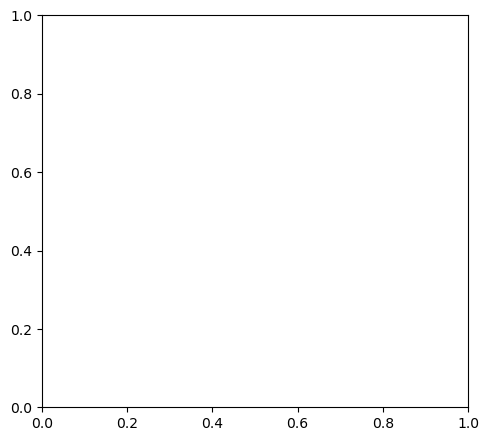

In [3]:
from tkinter import *
import pyodbc as odbc
import matplotlib.pyplot as plt
from tkinter import Tk, Label
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import ttk
from tkinter import messagebox
from tkcalendar import DateEntry
from datetime import datetime

# Connect to SQL Server
conn = odbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=DESKTOP-7I9UC6G\\SQLEXPRESS;"
    "DATABASE=python;"
    "Trusted_Connection=yes;"
)
cursor = conn.cursor()

def create_quotations_table():
    cursor.execute("""
        IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='Quotations' AND xtype='U')
        CREATE TABLE Quotations (
            QuotationID INT PRIMARY KEY IDENTITY(1,1),
            CustomerName VARCHAR(255),
            ProductName VARCHAR(255),
            Quantity INT,
            Price DECIMAL(10,2),
            QuotationDate DATE DEFAULT GETDATE(),
            OrderStatus VARCHAR(20) DEFAULT 'Pending'
        );
    """)
    conn.commit()
    print("✅ Quotations table created.")

def insert_dummy_quotations():
    """Populate some sample quotations so the UI is not empty."""
    demo_data = [
        ("Akash Sharma", "USB Flash Drive 32GB", 10, 5.99, "Pending"),
        ("Maya Verma", "Wireless Mouse", 3, 12.50, "Confirmed"),
        ("Rahul Singh", "Laptop Stand", 4, 19.99, "Pending"),
        ("Kavita Joshi", "Bluetooth Headphones", 2, 29.99, "Pending"),
        ("Aarav Das", "Webcam HD", 1, 39.99, "Confirmed"),
    ]

    # Insert only if table is empty
    cursor.execute("SELECT COUNT(*) FROM Quotations")
    if cursor.fetchone()[0] == 0:
        for row in demo_data:
            cursor.execute(
                """
                INSERT INTO Quotations (CustomerName, ProductName, Quantity, Price, OrderStatus)
                VALUES (?,?,?,?,?)
                """,
                row,
            )
        conn.commit()
        print("✅ Dummy quotations inserted.")

# Ensure quotations table & sample data exist
create_quotations_table()
insert_dummy_quotations()

# 1. Create table if it doesn't exist
def create_inventory_table():
    cursor.execute("""
        IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='Inventory' AND xtype='U')
        CREATE TABLE Inventory (
            ID INT PRIMARY KEY IDENTITY(1,1),
            ProductName VARCHAR(255),
            Quantity INT,
            Price DECIMAL(10,2),
            LastUpdated DATETIME DEFAULT GETDATE(),
            OrderConfirmed VARCHAR(20) DEFAULT 'Pending'
        );
    """)
    conn.commit()
    print("✅ Inventory table created successfully!")

# 2. Add unique constraint on ProductName
def add_unique_constraint():
    try:
        cursor.execute("""
            IF NOT EXISTS (
                SELECT * FROM sys.indexes 
                WHERE name='UQ_ProductName' AND object_id = OBJECT_ID('Inventory')
            )
            ALTER TABLE Inventory
            ADD CONSTRAINT UQ_ProductName UNIQUE (ProductName);
        """)
        conn.commit()
        print("✅ Unique constraint added to ProductName.")
    except Exception as e:
        print(f"❌ Error adding unique constraint: {e}")

# 3. Remove duplicates before adding constraint
def remove_duplicates():
    try:
        cursor.execute("""
            WITH CTE AS (
                SELECT *, ROW_NUMBER() OVER (PARTITION BY ProductName ORDER BY ID) AS RowNum
                FROM Inventory
            )
            DELETE FROM CTE WHERE RowNum > 1;
        """)
        conn.commit()
        print("✅ Duplicate products removed.")
    except Exception as e:
        print(f"❌ Error removing duplicates: {e}")

# 4. Temporarily disable FK constraints if blocking delete
def disable_foreign_keys():
    try:
        cursor.execute("""
            EXEC sp_msforeachtable "ALTER TABLE ? NOCHECK CONSTRAINT all"
        """)
        conn.commit()
        print("🔧 Foreign key constraints temporarily disabled.")
    except Exception as e:
        print(f"❌ Error disabling FK constraints: {e}")

def enable_foreign_keys():
    try:
        cursor.execute("""
            EXEC sp_msforeachtable "ALTER TABLE ? WITH CHECK CHECK CONSTRAINT all"
        """)
        conn.commit()
        print("🔧 Foreign key constraints re-enabled.")
    except Exception as e:
        print(f"❌ Error enabling FK constraints: {e}")

# 5. Reset inventory table
def reset_inventory():
    try:
        disable_foreign_keys()
        
        # Clean child table FIRST (to prevent FK conflict)
        cursor.execute("DELETE FROM Sales;")
        
        # Now clean parent table
        cursor.execute("DELETE FROM Inventory;")
        cursor.execute("DBCC CHECKIDENT ('Inventory', RESEED, 0);")
        
        conn.commit()
        enable_foreign_keys()
        print("✅ Inventory table reset successfully.")
    except Exception as e:
        print(f"❌ Error resetting inventory: {e}")
        
# 6. Insert dummy data
def insert_dummy_data():
    products = [
        ('USB Flash Drive 32GB', 50, 5.99, 'Pending'),
        ('Wireless Mouse', 25, 12.50, 'Confirmed'),
        ('Laptop Stand', 40, 19.99, 'Pending'),
        ('Bluetooth Headphones', 8, 29.99, 'Pending'),
        ('Webcam HD', 4, 39.99, 'Confirmed'),
        ('Mechanical Keyboard', 9, 59.99, 'Cancelled'),
        ('Smartphone Tripod', 0, 14.99, 'Pending'),  # ✅ Fixed: removed extra argument
        ('Portable Hard Drive 1TB', 0, 79.99, 'Pending'),
        ('Pack of AA Batteries', 60, 7.49, 'Confirmed'),
        ('HDMI Cable 2m', 12, 4.99, 'Pending')
    ]

    try:
        for product in products:
            cursor.execute("""
                INSERT INTO Inventory (ProductName, Quantity, Price, OrderConfirmed)
                VALUES (?, ?, ?, ?)
            """, product)
        conn.commit()
        print("✅ Dummy data inserted successfully!")
    except Exception as e:
        print(f"❌ Error inserting dummy data: {e}")

# 7. Ensure 'OrderConfirmed' column exists (redundant in your case, but kept for safety)
def add_order_confirmed_column():
    try:
        cursor.execute("""
            IF NOT EXISTS (
                SELECT * FROM INFORMATION_SCHEMA.COLUMNS 
                WHERE TABLE_NAME = 'Inventory' AND COLUMN_NAME = 'OrderConfirmed'
            )
            ALTER TABLE Inventory ADD OrderConfirmed VARCHAR(20) DEFAULT 'Pending';
        """)
        conn.commit()
        print("✅ OrderConfirmed column ensured.")
    except Exception as e:
        print(f"❌ Error ensuring OrderConfirmed column: {e}")

# 8. Insert single item manually
def insert_inventory(product_name, quantity, price, order_status="Pending"):
    try:
        cursor.execute(
            "INSERT INTO Inventory (ProductName, Quantity, Price, OrderConfirmed) VALUES (?, ?, ?, ?)",
            (product_name, quantity, price, order_status)
        )
        conn.commit()
        print("✅ Product added successfully!")
    except Exception as e:
        print(f"❌ Error adding product: {e}")

# 9. Update status
def update_order_status(product_name, status):
    try:
        cursor.execute(
            "UPDATE Inventory SET OrderConfirmed = ? WHERE ProductName = ?",
            (status, product_name)
        )
        conn.commit()
        print(f"✅ Order status for '{product_name}' updated to: {status}")
    except Exception as e:
        print(f"❌ Error updating order status: {e}")

def rename_orderconfirmed_to_status():
    try:
        cursor.execute("""
            IF EXISTS (
                SELECT * FROM INFORMATION_SCHEMA.COLUMNS
                WHERE TABLE_NAME = 'Inventory' AND COLUMN_NAME = 'OrderConfirmed'
            )
            EXEC sp_rename 'Inventory.OrderConfirmed', 'OrderStatus', 'COLUMN';
        """)
        conn.commit()
        print("✅ Column 'OrderConfirmed' successfully renamed to 'OrderStatus'.")
    except Exception as e:
        print(f"❌ Error renaming column: {e}")

# 10. Setup function
def setup_inventory():
    create_inventory_table()
    #rename_orderconfirmed_to_status()
    add_order_confirmed_column()
    remove_duplicates()
    add_unique_constraint()
    reset_inventory()
    insert_dummy_data()

# Run setup
setup_inventory()



def create_sales_table():
    cursor.execute("""
        IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='Sales' AND xtype='U')
        CREATE TABLE Sales (
            SaleID INT PRIMARY KEY IDENTITY(1,1),
            ProductID INT FOREIGN KEY REFERENCES Inventory(ID),
            QuantitySold INT,
            TotalPrice DECIMAL(10,2),
            SaleDate DATETIME DEFAULT GETDATE()
        );
    """)
    conn.commit()
    print("✅ Sales table created successfully!")

#create_sales_table()

def insert_sales(product_id, quantity_sold):
    #Get price from Inventory
    cursor.execute("SELECT Price FROM Inventory WHERE ID = ?", (product_id,))
    price = cursor.fetchone()
    
    if price:
        total_price = price[0] * quantity_sold
        
        ## Insert sales record
        cursor.execute("INSERT INTO Sales (ProductID, QuantitySold, TotalPrice) VALUES (?, ?, ?)",
                       (product_id, quantity_sold, total_price))
        
        ## Update inventory stock
        cursor.execute("UPDATE Inventory SET Quantity = Quantity - ? WHERE ID = ?", (quantity_sold, product_id))
        
        conn.commit()
        print("✅ Sale recorded successfully!")
    else:
         print("⚠️ Product ID not found!")

def create_employees_table():
    cursor.execute("""
    IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='Employees' AND xtype='U')
    CREATE TABLE Employees (
    ID INT PRIMARY KEY IDENTITY(1,1),
    Name VARCHAR(255),
    Position VARCHAR(255),
    Salary DECIMAL(10,2),
    HireDate DATE DEFAULT GETDATE()
    );
    """)
    conn.commit()
    print("✅ Employees table created successfully!")

# Function to insert sample employees
def insert_sample_employees():
    sample_data = [
        ("Amit Patel", "Manager", 75000, "2022-05-01"),
        ("Sofia Sharma", "Sales Executive", 45000, "2023-02-15"),
        ("Ravi Kumar", "Technician", 50000, "2021-11-10"),
        ("Priya Mehta", "Accountant", 60000, "2020-09-25"),
        ("Vikram Singh", "HR Specialist", 55000, "2023-07-03")
    ]
    
    cursor.executemany("INSERT INTO Employees (Name, Position, Salary, HireDate) VALUES (?, ?, ?, ?)", sample_data)
    conn.commit()
    print("✅ Sample employee records inserted successfully!")

## Call the functions
#create_employees_table()
#insert_sample_employees()

# Close connection
#cursor.close()
#conn.close()

def create_supplier_table():
    cursor.execute("""
        IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='Suppliers' AND xtype='U')
        CREATE TABLE Suppliers (
            ID INT PRIMARY KEY IDENTITY(1,1),
            Name VARCHAR(255),
            Company VARCHAR(255),
            Contact VARCHAR(15),
            Materials VARCHAR(500)
        );
    """)
    conn.commit()
    print("✅ Suppliers table created successfully!")

def insert_sample_suppliers():
    sample_suppliers = [
        ("Rajesh Patel", "TechCorp Pvt Ltd", "9876543210", "Electronic Components, Sensors"),
        ("Neha Sharma", "Green Energy Ltd", "9123456789", "Solar Panels, Batteries"),
        ("Amit Gupta", "SteelWorks Industries", "8997766554", "Steel Frames, Pipes"),
        ("Sofia Mehta", "Alpha Traders", "9911223344", "Wires, Cables, Electrical Tools"),
        ("Ravi Kumar", "SuperTech Solutions", "9001122334", "Computers, Hardware Parts")
    ]

    for supplier in sample_suppliers:
        cursor.execute("SELECT COUNT(*) FROM Suppliers WHERE Name = ? AND Company = ?", (supplier[0], supplier[1]))
        existing_count = cursor.fetchone()[0]

        if existing_count == 0:  # If supplier does not exist, insert the record
            cursor.execute("INSERT INTO Suppliers (Name, Company, Contact, Materials) VALUES (?, ?, ?, ?)", supplier)
            
    conn.commit()
    print("✅ Sample supplier records inserted successfully (No duplicates added)!")

create_supplier_table()
insert_sample_suppliers()

def create_orders_table():
    cursor.execute("""
        IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='Orders' AND xtype='U')
        CREATE TABLE Orders (
            OrderID INT PRIMARY KEY IDENTITY(1,1),
            CustomerID INT,
            ProductID INT,
            Quantity INT,
            TotalAmount DECIMAL(10,2),
            OrderDate DATETIME DEFAULT GETDATE(),
            Status VARCHAR(50) DEFAULT 'Pending',
            PaymentMethod VARCHAR(50),
            ShippingAddress TEXT,
            LastUpdated DATETIME DEFAULT GETDATE()
        );
    """)
    conn.commit()
    print("✅ Orders table created successfully!")

create_orders_table()

# Function to make frames clickable
def make_frame_clickable(frame, title, callback):
    frame.bind("<Button-1>", lambda e: callback(title))
    for child in frame.winfo_children():
        child.bind("<Button-1>", lambda e: callback(title))

root=Tk()
root.title('Dashboard')
root.geometry('1350x690+0+0')  # +0+0 means distance of frame will be 0 from x and y axis
root.config(bg='#5761B2')

from tkinter import Toplevel

notifications = []

notif_frame = ttk.Frame(root)
notif_frame.pack(pady=20)

# Function to fetch recent changes from database
def fetch_notifications():
    cursor.execute("SELECT TOP 5 'New sale recorded!' FROM Sales ORDER BY SaleDate DESC")
    new_sales = cursor.fetchall()
    
    cursor.execute("SELECT TOP 5 'Inventory updated!' FROM Inventory ORDER BY LastUpdated DESC")
    new_inventory = cursor.fetchall()
    
    cursor.execute("SELECT TOP 5 'Supplier added successfully!' FROM Suppliers ORDER BY ID DESC")
    new_suppliers = cursor.fetchall()

    latest_notifications = [notif[0] for notif in (new_sales + new_inventory + new_suppliers)]
    
    return latest_notifications

def update_notification_display(notif_window, scroll_frame):
    for widget in scroll_frame.winfo_children():
        widget.destroy()  # Clear old notifications

    Label(scroll_frame, text="Recent Notifications:", font=('times new roman', 15, 'bold')).pack(pady=10)

    notifications = fetch_notifications()
    
    for notif in notifications:
        Label(scroll_frame, text=f"- {notif}", font=('times new roman', 13), fg="white", bg="#2C3E50", padx=10, pady=5).pack(anchor="w", padx=20)

    # Re-run this function every 5 seconds
    notif_window.after(5000, lambda: update_notification_display(notif_window, scroll_frame))


# Function to open notifications window
def open_notifications():
    notif_window = Toplevel(root)
    notif_window.title("Notifications")
    notif_window.geometry("400x300+500+200")
    notif_window.config(bg="#2C3E50") 
    
    Label(notif_window, text="🔔 Notifications:", font=('times new roman', 20, 'bold')).pack(pady=10)

    canvas = Canvas(notif_window, bg="#2C3E50")
    scrollbar = Scrollbar(notif_window, orient="vertical", command=canvas.yview)
    scroll_frame = Frame(canvas, bg="#2C3E50")

    scroll_frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

    canvas.create_window((0, 0), window=scroll_frame, anchor="nw")
    canvas.configure(yscrollcommand=scrollbar.set)

    update_notification_display(notif_window, scroll_frame)
   
    canvas.pack(side="left", fill="both", expand=True)
    scrollbar.pack(side="right", fill="y")

    Button(notif_window, text="Close", command=notif_window.destroy).pack(pady=15)

                                                                                                                                  
bg_image=PhotoImage(file='inventory (2).png')
titleLabel=Label(root, image=bg_image ,compound=LEFT,  text='Inventory Managment System', font=('times new roman', 40, 'bold'), bg='#010c48', fg='white', anchor='w', padx=20)
titleLabel.place(x=0,y=0, relwidth=1)

bell_icon = PhotoImage(file="bell.png")  # Ensure you have a bell.png file
bell_button = Button(root, image=bell_icon, command=open_notifications, bd=2)
bell_button.place(x=1120, y=17)  # Adjust position as needed970, y=150

LogoutButton=Button(root, text='Logout', font=('times new roman', 20, 'bold'))
LogoutButton.place(x=1200,y=9)

subtitle=Label(root, text='Welcome Admin\t\t Date: 08-07-2024\t\t Time: 12:36:13 pm', font=('times new roman', 15),bg='#4d636d', fg='white')
subtitle.place(x=0, y=68, relwidth=1)

leftFrame=Frame(root)
leftFrame.place(x=0, y=96, width=200, height=595)

logoImage=PhotoImage(file='checklist (1).png')
ImageLabel=Label(leftFrame, image=logoImage)
ImageLabel.pack()

menuLabel=Label(leftFrame, text='Menu', font=('times new roman',20),bg='#009688')
menuLabel.pack(fill=X)

emp_image=PhotoImage(file='employee.png')
employee_button=Button(leftFrame, image=emp_image ,compound=LEFT,  text='Employees', font=('times new roman', 20, 'bold'))
employee_button.pack(fill=X)

product_image=PhotoImage(file='box.png')
Product_button=Button(leftFrame, image=product_image, compound=LEFT, text='Products', font=('times new roman', 20, 'bold'))
Product_button.pack(fill=X)

panel_image=PhotoImage(file='solar.png')
Panel_button=Button(leftFrame, image=panel_image ,compound=LEFT,  text='Panels', font=('times new roman', 20, 'bold'))
Panel_button.pack(fill=X)

Inventory_image=PhotoImage(file='inventory (1).png')
Inventory_button=Button(leftFrame, image=Inventory_image ,compound=LEFT, text='Inventory', font=('times new roman', 20, 'bold'))
Inventory_button.pack(fill=X)

billing_image=PhotoImage(file='bill.png')
Billing_button=Button(leftFrame, image=billing_image ,compound=LEFT, text='Billing', font=('times new roman', 20, 'bold'))
Billing_button.pack(fill=X)

sales_image=PhotoImage(file='increase.png')
sales_button=Button(leftFrame, image=sales_image ,compound=LEFT, text='Sales', font=('times new roman', 20, 'bold'))
sales_button.pack(fill=X)

help_image=PhotoImage(file='chat.png')
help_button=Button(leftFrame, image=help_image ,compound=LEFT, text='Help', font=('times new roman', 20, 'bold'))
help_button.pack(fill=X)

exit_image=PhotoImage(file='exit.png')
exit_button=Button(leftFrame, image=exit_image ,compound=LEFT, text='Exit', font=('times new roman', 20, 'bold'))
exit_button.pack(fill=X)


graphtitle=Label(root, text='📊 Buisness Overview', font=('times new roman', 17, 'bold'), bg='#7BD5F5')
graphtitle.place(x=970, y=130)

fig, ax = plt.subplots(figsize=(5.5, 5.1))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().place(x=780, y=170)

def update_graph(data, title, chart_type="bar"):
    ax.clear()
    ax.set_title(title, fontsize=14)

    if not data:
        ax.text(0.5, 0.5, "No data to display", fontsize=12, ha='center', va='center')
        canvas.draw()
        canvas.get_tk_widget().update_idletasks()
        return

    labels = [str(row[0]) for row in data]

    def safe_float(val):
        try:
            return float(val)
        except (ValueError, TypeError):
            return 0
            
    values = [safe_float(row[1]) for row in data]

    # Plot based on chart type
    if chart_type == "bar":
        ax.bar(labels, values, color="#61AFEF")
    elif chart_type == "line":
        ax.plot(labels, values, color="#EF476F", marker='o', linestyle='-')
    elif chart_type == "pie":
        if sum(values) == 0:
            ax.text(0.5, 0.5, "No valid data for pie chart", fontsize=12, ha='center', va='center')
        else:
            ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
            ax.axis('equal')  # Make pie chart circular
    else:
        ax.text(0.5, 0.5, "Invalid chart type", fontsize=12, ha='center', va='center')

    # Styling for bar and line charts
    if chart_type in ("bar", "line"):
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', va='top')
        # Padding
        ax.tick_params(axis='x', pad=10)

    # Adjust layout to prevent clipping
    fig.tight_layout()

    # Redraw the canvas
    canvas.draw()
    canvas.get_tk_widget().update_idletasks()


def show_data_in_window(title, data, columns):
    if not data or not columns:
        print("No data or columns provided.")
        return

    def search_tree():
        query = search_var.get().lower()
        for row in tree.get_children():
            tree.delete(row)

        for item in data:
            if any(query in str(value).lower() for value in item):
                tree.insert("", "end", values=[str(value) for value in item])

    data_window = Toplevel(root)
    data_window.title(title)
    data_window.geometry(f"{root.winfo_screenwidth()}x{root.winfo_screenheight()}")
    data_window.state('zoomed')
    data_window.config(bg="#96C3EB")

    Label(data_window, text=title, font=('times new roman', 30, 'bold'), bg="#158FAD", fg="white", pady=20).pack()

    search_frame = Frame(data_window, bg="#96C3EB")
    search_frame.pack(pady=5)

    search_var = StringVar()
    Entry(search_frame, textvariable=search_var, font=('times new roman', 14), width=40).pack(side=LEFT, padx=10)
    Button(search_frame, text="Search", font=('times new roman', 12, 'bold'),
           command=search_tree).pack(side=LEFT)

    frame = Frame(data_window, bg="#96C3EB", bd=5, relief=SOLID)
    frame.pack(expand=True, fill="both", padx=20, pady=20)

    v_scrollbar = Scrollbar(frame, orient=VERTICAL)
    h_scrollbar = Scrollbar(frame, orient=HORIZONTAL)
    v_scrollbar.pack(side=RIGHT, fill=Y)
    h_scrollbar.pack(side=BOTTOM, fill=X)
    
    tree = ttk.Treeview(frame, columns=columns, show="headings", yscrollcommand=v_scrollbar.set , xscrollcommand=h_scrollbar.set)
    tree.pack(expand=True, fill="both")
    v_scrollbar.config(command=tree.yview)
    h_scrollbar.config(command=tree.xview)

    for col in columns:
        tree.heading(col, text=col, anchor=CENTER)
        tree.column(col, anchor=CENTER, width=200)

    style = ttk.Style()
    style.configure("Treeview", font=("times new roman", 15), rowheight=30, background="#ECF0F1", foreground="black")
    style.configure("Treeview.Heading", font=("times new roman", 18, "bold"), background="black", foreground="black")

    for item in data:
        tree.insert("", "end", values=[str(value) for value in item])

    Button(data_window, text="Close", font=('times new roman', 15, 'bold'),
           command=data_window.destroy).pack(pady=20)

def fetch_employee_data():
    cursor.execute("SELECT ID, Name, Position, Salary, HireDate FROM Employees")
    employees = cursor.fetchall()
    return employees

def open_employee_window(title):
    employees = fetch_employee_data() 
    show_data_in_window(title, employees, ["ID","Name","Position","Salary","Hire Date"])
    update_graph([(row[1], row[3]) for row in employees], "Employee Salaries", chart_type="bar")

emp_frame=Frame(root, bg='#2C3E50', bd=3,  relief=RIDGE)
emp_frame.place(x=230, y=125, height=170, width=230)
total_emp_image=PhotoImage(file='team.png')
total_emp_image_label=Label(emp_frame, image=total_emp_image, bg='#2C3E50')
total_emp_image_label.pack()
total_emp_label=Label(emp_frame, text='Staffing Overview', font=('times new roman', 15, 'bold') ,bg='#2C3E50', fg='white')
total_emp_label.pack()
total_emp_count_label=Label(emp_frame, text='0', bg='#2C3E50',fg='white', font=('times new roman', 20, 'bold'))
total_emp_count_label.pack()
make_frame_clickable(emp_frame, 'Staffing Overview', open_employee_window)

def fetch_supplier_data():
    cursor.execute("SELECT ID, Name, Company, Contact, Materials FROM Suppliers")
    suppliers = cursor.fetchall()
    return suppliers
    
def open_supplier_window(title):
    from collections import Counter 
    suppliers = fetch_supplier_data()  # Fetch supplier details
    show_data_in_window(title, suppliers, ["ID","Name","Company","Contact","Materials"])
    company_counts = Counter(row[2] for row in suppliers)
    update_graph(list(company_counts.items()), "Suppliers by Company", chart_type="pie")

sup_frame=Frame(root, bg='#8E44AD', bd=3, relief=RIDGE)
sup_frame.place(x=520, y=125, height=170, width=230)
total_sup_image=PhotoImage(file='supplier.png')
total_sup_image_label=Label(sup_frame, image=total_sup_image, bg='#8E44AD')
total_sup_image_label.pack()
total_sup_label=Label(sup_frame, text='Supplier Network', font=('times new roman', 15, 'bold') ,bg='#8E44AD', fg='white')
total_sup_label.pack()
total_sup_count_label=Label(sup_frame, text='0', bg='#8E44AD',fg='white', font=('times new roman', 20, 'bold'))
total_sup_count_label.pack()
make_frame_clickable(sup_frame, 'Vendor Ecosystem', open_supplier_window)

def open_revenue_window(title):
    revenue_data = [("Q1", 20000), ("Q2", 30000), ("Q3", 40000), ("Q4", 50000)]
    update_graph(revenue_data, "Quarterly Revenue", chart_type="line")
    messagebox.showinfo("Coming Soon", "Revenue insights coming soon!")

revenue_frame=Frame(root, bg='#007FFF', bd=3, relief=RIDGE)
revenue_frame.place(x=230, y=310, height=170, width=230)
total_revenue_image=PhotoImage(file='revenue.png')
total_revenue_image_label=Label(revenue_frame, image=total_revenue_image, bg='#007FFF')
total_revenue_image_label.pack()
total_revenue_label=Label(revenue_frame, text='Revenue Insights', font=('times new roman', 15, 'bold') ,bg='#007FFF', fg='white')
total_revenue_label.pack()
total_revenue_count_label=Label(revenue_frame, text='0', bg='#007FFF',fg='white', font=('times new roman', 20, 'bold'))
total_revenue_count_label.pack()
make_frame_clickable(revenue_frame, 'Revenue Insights', open_revenue_window)


def show_data_in_product_window(title, data, columns):
    data_window = Toplevel(root)
    data_window.title(title)
    data_window.geometry(f"{root.winfo_screenwidth()}x{root.winfo_screenheight()}")
    data_window.state('zoomed')
    data_window.config(bg="#96C3EB")

    Label(data_window, text=title, font=('times new roman', 30, 'bold'), bg="#158FAD", fg="white", pady=20).pack(fill=X)

     # === Search and Date Filter Bar ===
    filter_frame = Frame(data_window, bg="#96C3EB")
    filter_frame.pack(pady=10, padx=20, fill=X)

    Label(filter_frame, text="Search Customer", font=('times new roman', 14), bg="#96C3EB").pack(side=LEFT)
    search_var = StringVar()
    search_entry = Entry(filter_frame, textvariable=search_var, font=('times new roman', 14), width=30)
    search_entry.pack(side=LEFT, padx=10)

    # Date range selection
    Label(filter_frame, text="From:", font=('times new roman', 14), bg="#96C3EB").pack(side=LEFT, padx=(20, 5))
    from_date = DateEntry(filter_frame, font=('times new roman', 14), date_pattern='yyyy-mm-dd')
    from_date.pack(side=LEFT)

    Label(filter_frame, text="To:", font=('times new roman', 14), bg="#96C3EB").pack(side=LEFT, padx=(20, 5))
    to_date = DateEntry(filter_frame, font=('times new roman', 14), date_pattern='yyyy-mm-dd')
    to_date.pack(side=LEFT)

    Button(filter_frame, text="Filter", font=('times new roman', 12), command=lambda: filter_table(), bg="#158FAD", fg="white"
          ).pack(side=LEFT, padx=20)

 
    # === Scrollable Canvas Setup ===
    canvas_frame = Frame(data_window)
    canvas_frame.pack(expand=True, fill=BOTH)

    canvas = Canvas(canvas_frame, bg="#96C3EB")
    canvas.pack(side=LEFT, fill=BOTH, expand=True)

    v_scroll = Scrollbar(canvas_frame, orient=VERTICAL, command=canvas.yview)
    v_scroll.pack(side=RIGHT, fill=Y)

    h_scroll = Scrollbar(data_window, orient=HORIZONTAL, command=canvas.xview)
    h_scroll.pack(side=BOTTOM, fill=X)
   
    canvas.configure(yscrollcommand=v_scroll.set, xscrollcommand=h_scroll.set)

    table_frame = Frame(canvas, bg="#EAF4FF")
    table_window= canvas.create_window((0, 0), window=table_frame, anchor="nw")

    def update_scrollregion(event=None):
        canvas.configure(scrollregion=canvas.bbox("all"))
        # Optional: Resize canvas window width
        canvas.itemconfig(table_window, width=canvas.winfo_width())

    table_frame.bind("<Configure>", update_scrollregion)
    canvas.bind("<Configure>", update_scrollregion)


    product_vars = {}
    product_names = {}

    # === Function to Populate the Table ===
    def render_table(filtered_data):
        for widget in table_frame.winfo_children():
            widget.destroy()

        headers = ["Select"] + columns
        for col_index, header in enumerate(headers):
            col_width = 6 if col_index == 0 else 18  # ✅ Narrow checkbox column
            Label(table_frame, text=header, font=('times new roman', 14, 'bold'), bg="#158FAD", fg="white", width=col_width, anchor="center"
                 ).grid(row=0, column=col_index, sticky="nsew", padx=2, pady=4)

        for row_index, row_data in enumerate(filtered_data):
            index = row_index
            var = IntVar()
            product_vars[index] = var
            product_names[index] = row_data[0]

            Checkbutton(table_frame, variable=var, bg="#EAF4FF").grid(row=row_index + 1, column=0, sticky="w", padx=5, pady=2)

            for col_index, cell_value in enumerate(row_data):
                Label(table_frame, text=str(cell_value), font=('times new roman', 12), bg="#EAF4FF",
                      anchor="center", justify=CENTER, width=15
                     ).grid(row=row_index + 1, column=col_index + 1, sticky="nsew", padx=2, pady=2)

    # === Filter Handler ===
    def filter_table(*args):
        query = search_var.get().strip().lower()
        from_d = from_date.get_date()
        to_d = to_date.get_date()

        def match(row):
            name_match = query in row[0].lower()
            try:
                row_date = datetime.strptime(row[3], '%Y-%m-%d').date()  # Assuming LastUpdated is at index 3
                date_match = from_d <= row_date <= to_d
            except Exception:
                date_match = False
            return name_match and date_match

        filtered = [row for row in data if match(row)]
        render_table(filtered)

    search_var.trace_add("write", filter_table)
    render_table(data)

    def _on_mousewheel(event):
        canvas.yview_scroll(int(-1*(event.delta/120)), "units")
        canvas.xview_scroll(int(-1*(event.delta/120)), "units") 
    canvas.bind("<MouseWheel>", _on_mousewheel)

    # === Process Button Action ===
    def update_selected_rows(new_status):
        selected_rows = [data[i] for i, v in product_vars.items() if v.get() == 1]
        if not selected_rows:
            messagebox.showwarning("No Selection", "Please select at least one quotation.")
            return

        try:
            for row in selected_rows:
                cursor.execute(
                    "UPDATE Quotations SET OrderStatus = ? WHERE CustomerName = ? AND ProductName = ? AND QuotationDate = ?",
                    (new_status, row[0], row[1], row[4]),
                )
            conn.commit()
            messagebox.showinfo("Success", f"Selected quotations marked as '{new_status}'.")
            # refresh data
            refreshed = fetch_customer_quotations()
            render_table(refreshed)
            update_graph([(r[1], r[2]) for r in refreshed], "Quotation Quantities", chart_type="bar")
        except Exception as exc:
            conn.rollback()
            messagebox.showerror("Error", str(exc))

    # === Action Buttons ===
    btn_frame = Frame(data_window, bg="#96C3EB")
    btn_frame.pack(pady=20)

    Button(btn_frame, text="Confirm", font=('times new roman', 15, 'bold'), bg="green", fg="white", width=12, command=lambda: update_selected_rows("Confirmed")
          ).pack(side=LEFT, padx=40)

    Button(btn_frame, text="Cancel", font=('times new roman', 15, 'bold'),bg="red", fg="white", width=12,command=lambda: update_selected_rows("Cancelled")
          ).pack(side=LEFT, padx=40)

    Button(btn_frame, text="Close", font=('times new roman', 15, 'bold'), command=data_window.destroy, width=12
          ).pack(side=LEFT, padx=40)

def fetch_customer_quotations():
    cursor.execute("SELECT CustomerName, ProductName, Quantity, Price, QuotationDate, OrderStatus FROM Quotations")
    return cursor.fetchall()

def open_quotation_window(_=None):
    rows = fetch_customer_quotations()
    show_data_in_product_window(
        "Customer Quotations",
        rows,
        ["CustomerName", "ProductName", "Quantity", "Price", "QuotationDate", "OrderStatus"],
    )
    update_graph([(r[1], r[2]) for r in rows], "Quotation Quantities", chart_type="bar")


product_frame=Frame(root, bg='#007BA7', bd=3, relief=RIDGE)
product_frame.place(x=520, y=310, height=170, width=230)
total_product_image=PhotoImage(file='delivery-box.png')
total_product_image_label=Label(product_frame, image=total_product_image, bg='#007BA7')
total_product_image_label.pack()
total_product_label=Label(product_frame, text='Quotation', font=('times new roman', 15, 'bold') ,bg='#007BA7', fg='white')
total_product_label.pack()
total_product_count_label=Label(product_frame, text='0', bg='#007BA7',fg='white', font=('times new roman', 20, 'bold'))
total_product_count_label.pack()
make_frame_clickable(product_frame, "Quotation",  open_quotation_window)

def fetch_order_status():
    cursor.execute("Select OrderID, CustomerID, ProductID, Quantity, TotalAmount, OrderDate, Status, PaymentMethod, ShippingAddress FROM Orders")
    return cursor.fetchall()

def open_order_window(title):
    order_data = fetch_order_status() 
    show_data_in_window(title, order_data, ["OrderID", "CustomerID", "ProductID", "Quantity", "TotalAmount", "OrderDate", "Status", "PaymentMethod", "ShippingAddress"])
    update_graph([(row[0], row[3]) for row in order_data], "Order Quantities", chart_type="bar")


order_frame=Frame(root, bg='#0095B6', bd=3, relief=RIDGE)
order_frame.place(x=375, y=500, height=170, width=230)
total_order_image=PhotoImage(file='check-out.png')
total_order_image_label=Label(order_frame, image=total_order_image, bg='#0095B6')
total_order_image_label.pack()
total_order_label=Label(order_frame, text="Logistics & Dispatch", font=('times new roman', 15, 'bold') ,bg='#0095B6', fg='white')
total_order_label.pack()
total_order_count_label=Label(order_frame, text='0', bg='#0095B6',fg='white', font=('times new roman', 20, 'bold'))
total_order_count_label.pack()
make_frame_clickable(order_frame, "Logistics & Dispatch", open_order_window)

root.mainloop()